# BEGIN

In [1]:
%reload_ext autoreload
%autoreload 2

# https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
# https://github.com/opencv/opencv/blob/master/samples/python/calibrate.py

In [2]:
import cv2, os, numpy as np, glob, matplotlib.pyplot as plt, tqdm

In [3]:
def drawChessboardCorners(image, pattern_size, scale_corners, ret, is_show = True):
    if ret==False: return image
    scale_corners = np.squeeze(scale_corners)
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (255, 128, 0), (255, 0, 128), (128, 255, 0)]
    circle_size = 25
    line_size   = 25
    
    new_image  = image.copy()
    
    rows, cols = pattern_size[0], pattern_size[1]
    centerp = center = None
    for r in range(rows):
        for c in range(cols):
            centerp = center
            center  = tuple(scale_corners[r * cols + c, :].astype(np.int))
            if centerp is not None:
                cv2.line(new_image, center, centerp, colors[r], line_size)
            # if
            new_image = cv2.circle(new_image, center, circle_size, colors[r], -1)
    # for
    
    if is_show == True:
        plt.figure(figsize=(12, 12))
        plt.imshow(new_image[...,::-1])
        plt.axis("off")
    # if

    return new_image
# drawChessboardCorners

## 1. Detect ChessboardCorners to find 3D-2D corresponding

In [4]:
search_pattern = "./data/calibration/Note8a/*.jpg"

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

pattern_size = (7, 7)
scale        = 4
square_size  = 1.0

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((np.prod(pattern_size), 3), np.float32)
objp[:,:2] = np.indices(pattern_size).T.reshape(-1, 2)
objp *= square_size

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

path_images = glob.glob(search_pattern)
path_images.sort()

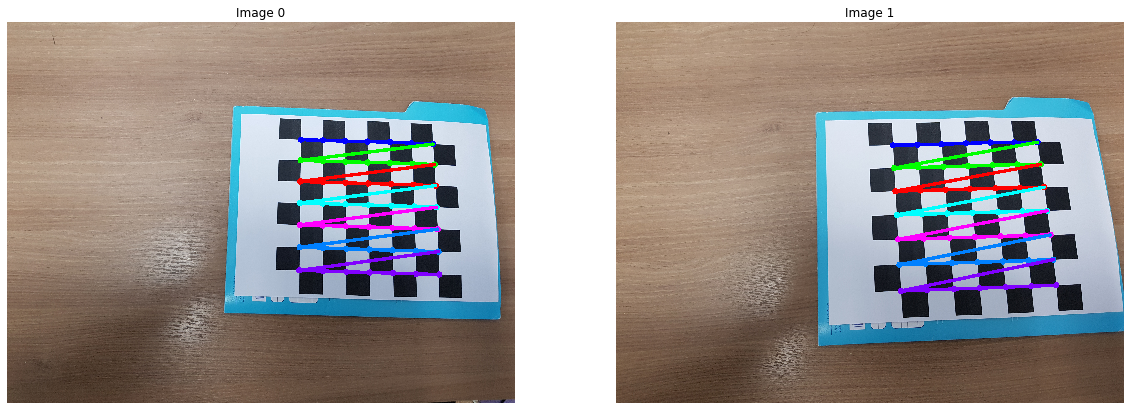

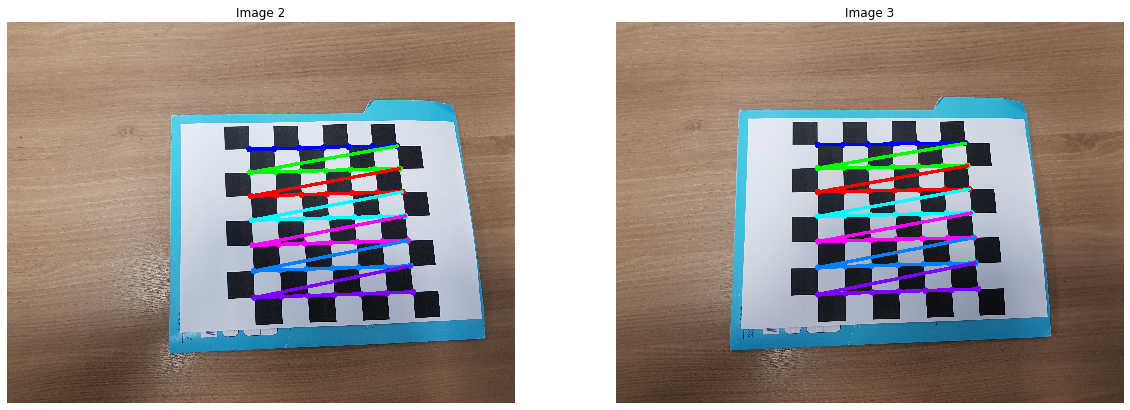

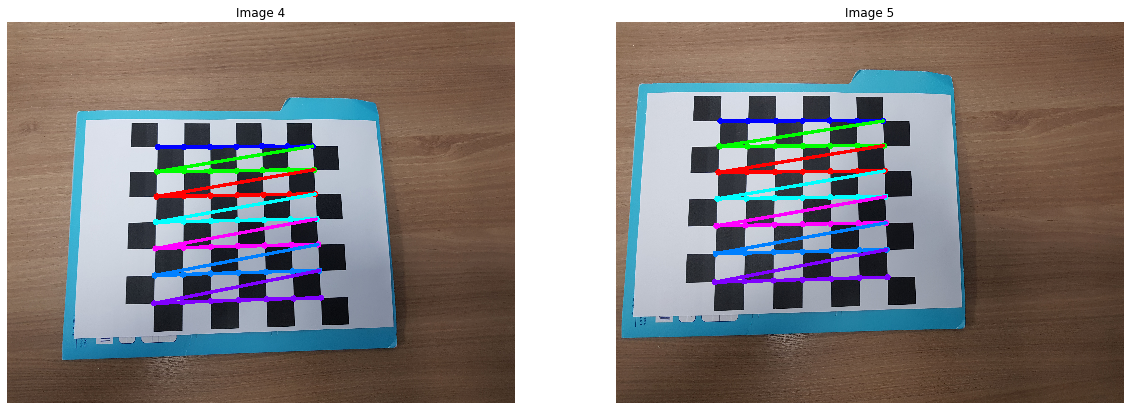

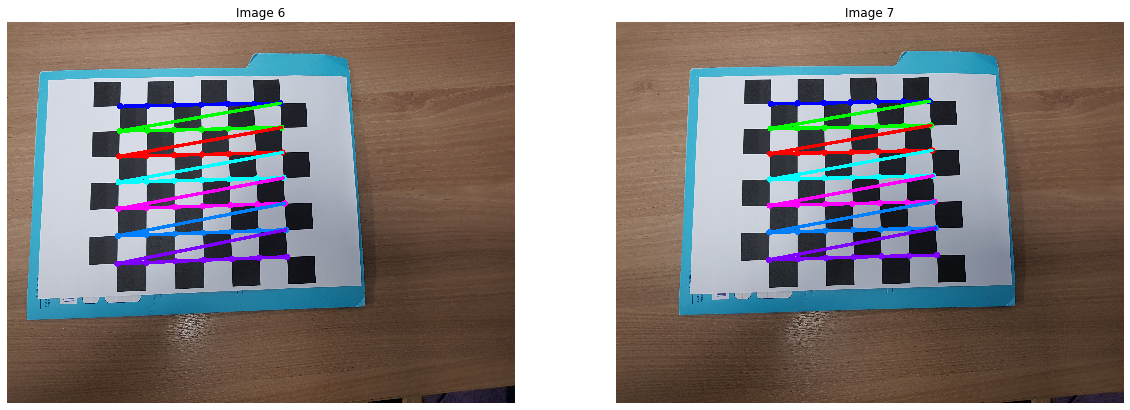

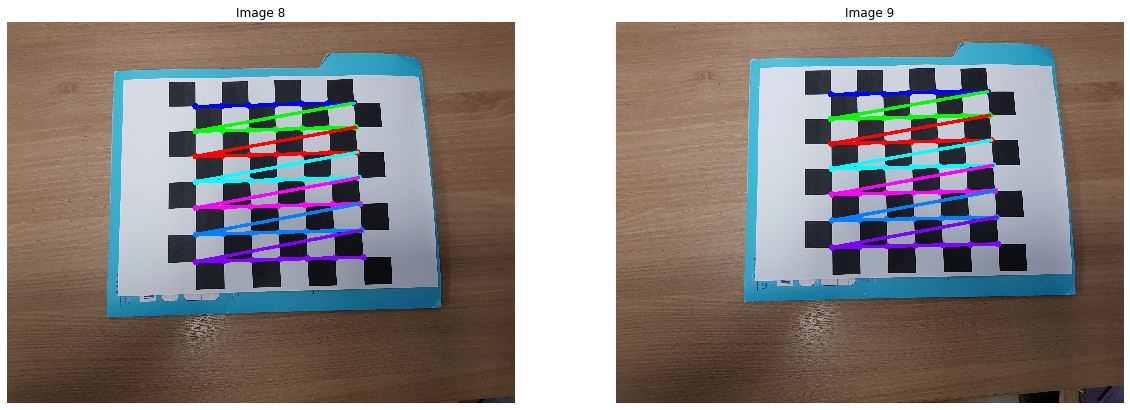

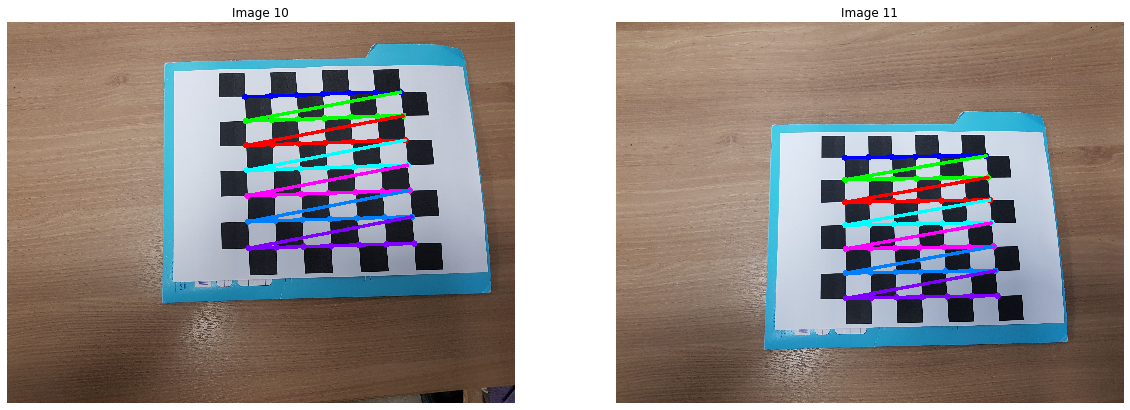

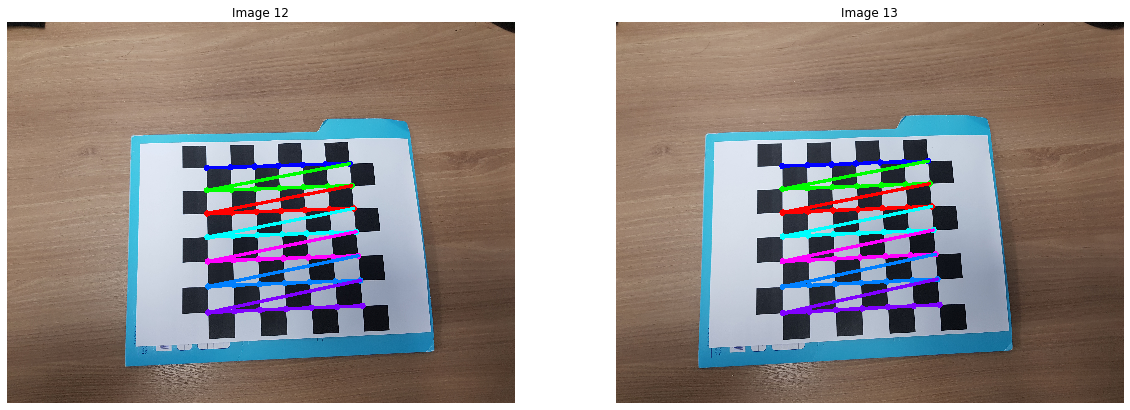

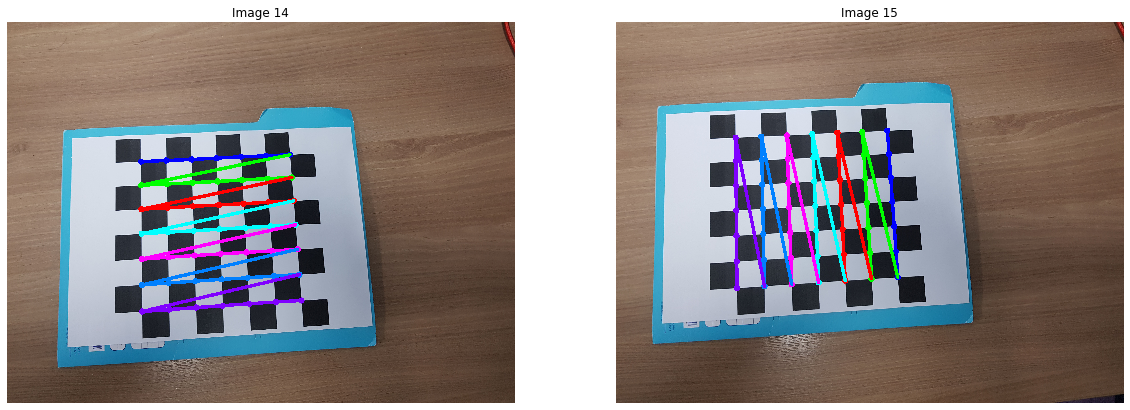

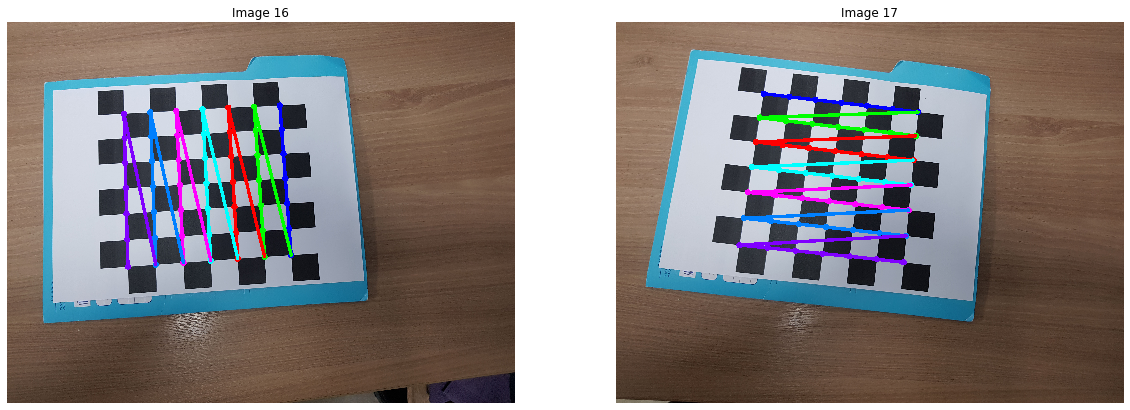

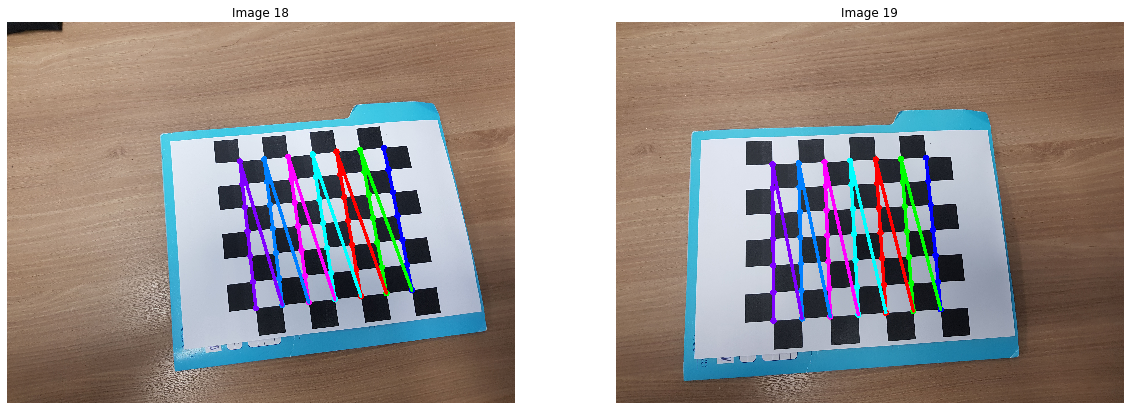

In [5]:
obj_points = []
img_points = []
images     = []

cols = 2
rows = (len(path_images) + cols - 1) // cols
idx_image = 0
for r in range(rows):
    plt.figure(figsize = (20, 7))
    for c in range(cols):
        idx_pos = r * cols + c
        if idx_pos >= len(path_images): continue
        fname = path_images[idx_pos]
        
        org_image   = cv2.imread(fname)
        org_gray    = cv2.cvtColor(org_image, cv2.COLOR_BGR2GRAY)

        org_height, org_width = org_image.shape[:2]
        new_height, new_width = org_height // scale, org_width // scale

        scale_image = cv2.resize(org_image, (new_width, new_height), cv2.INTER_CUBIC)
        gray = cv2.cvtColor(scale_image, cv2.COLOR_BGR2GRAY)


        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, pattern_size, None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            corners = np.squeeze(corners)
            corners2 = cv2.cornerSubPix(gray, corners, (pattern_size[0]//2, pattern_size[1]// 2), (-1,-1),criteria)
            scale_corners = cv2.cornerSubPix(org_gray, corners2 * scale, (pattern_size[0]//2, pattern_size[1]// 2), (-1,-1),criteria)

            # Draw and display the corners
            ret_image = drawChessboardCorners(org_image, pattern_size, scale_corners, ret, is_show = False)

            images.append(org_image)
            obj_points.append(objp)
            img_points.append(scale_corners)

            plt.subplot(1, cols, c + 1), plt.imshow(ret_image[...,::-1])
            plt.title(f"Image {idx_image}")
            plt.axis("off")
            
            idx_image = idx_image + 1
        # if
    # for
    plt.show()
# for

In [6]:
idx_filter = [idx for idx in range(len(img_points)) if idx not in [15, 16, 18, 19]]

In [7]:
img_points = np.squeeze(np.array(img_points))
obj_points = np.array(obj_points)

In [8]:
img_points_filter = img_points[idx_filter]
obj_points_filter = obj_points[idx_filter]

## 2. Calibrate Camera

In [9]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points, img_points, 
                                                                     (org_width, org_height), None, None)

In [10]:
print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())


RMS: 1.1175393693050937
camera matrix:
 [[3.55790612e+03 0.00000000e+00 2.05991926e+03]
 [0.00000000e+00 3.45462241e+03 1.49734905e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 0.08791635 -0.26319236  0.01067034 -0.00325333 -1.33233556]


In [11]:
obj_points_test = obj_points # obj_points_filter
img_points_test = img_points # img_points_filter

mean_error = 0
for i in range(len(obj_points_test)):
    img_points2, _ = cv2.projectPoints(obj_points_test[i], _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)
    img_points2    = np.squeeze(img_points2)
    error = cv2.norm(img_points_test[i],img_points2, cv2.NORM_L2)/len(img_points2)
    mean_error += error
# for
print("total error: ", mean_error/len(obj_points_test))

total error:  0.15705153472766437


In [12]:
np.savez("calibrate0.npz", 
         camera_matrix = camera_matrix, 
         dist_coefs = dist_coefs, 
         mean_error = mean_error)

In [13]:
# calculate camera distortion
rms, camera_matrix, dist_coefs, _rvecs, _tvecs = cv2.calibrateCamera(obj_points_filter, img_points_filter, 
                                                                     (org_width, org_height), None, None)

In [14]:
print("\nRMS:", rms)
print("camera matrix:\n", camera_matrix)
print("distortion coefficients: ", dist_coefs.ravel())


RMS: 1.1109043547739383
camera matrix:
 [[3.79408157e+03 0.00000000e+00 2.06101782e+03]
 [0.00000000e+00 3.68800639e+03 1.49115819e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
distortion coefficients:  [ 0.10490643 -0.37527144  0.01191867 -0.00377387 -1.86075126]


In [15]:
obj_points_test = obj_points_filter
img_points_test = img_points_filter

mean_error = 0
for i in range(len(obj_points_test)):
    img_points2, _ = cv2.projectPoints(obj_points_test[i], _rvecs[i], _tvecs[i], camera_matrix, dist_coefs)
    img_points2    = np.squeeze(img_points2)
    error = cv2.norm(img_points_test[i],img_points2, cv2.NORM_L2)/len(img_points2)
    mean_error += error
# for
print("total error: ", mean_error/len(obj_points_test))

total error:  0.15603712482212448


In [16]:
np.savez("calibrate1.npz", 
         camera_matrix = camera_matrix, 
         dist_coefs = dist_coefs, 
         mean_error = mean_error)

## 3. Undistortion

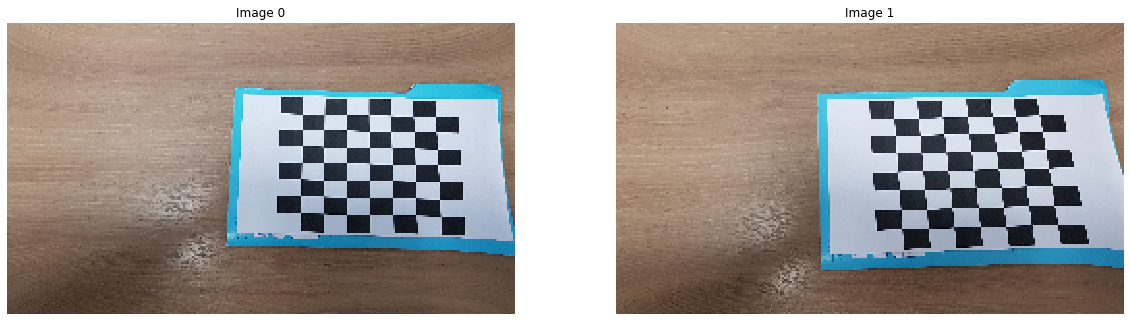

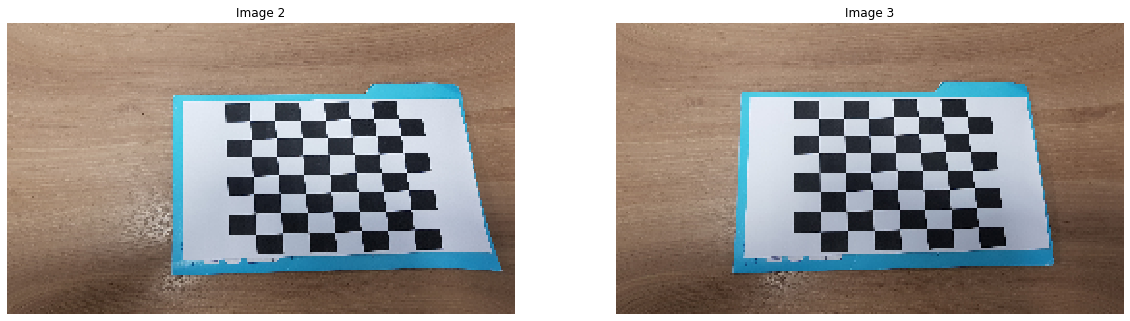

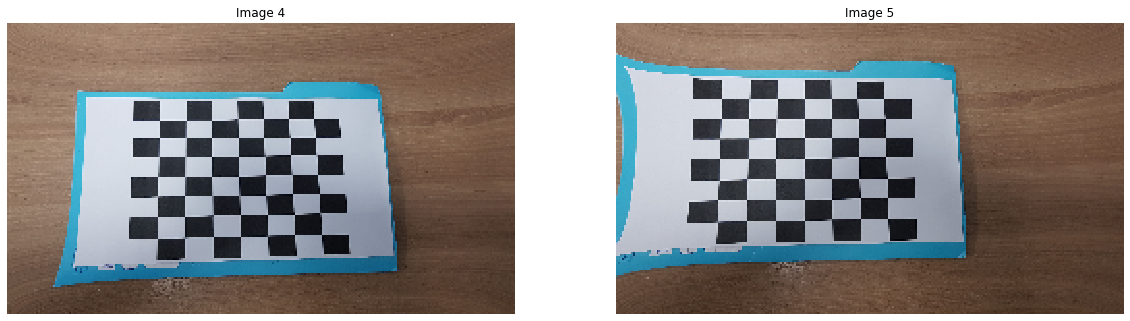

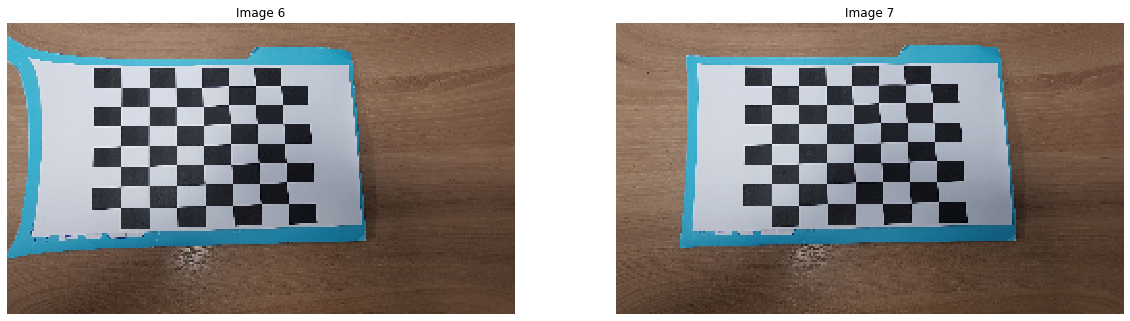

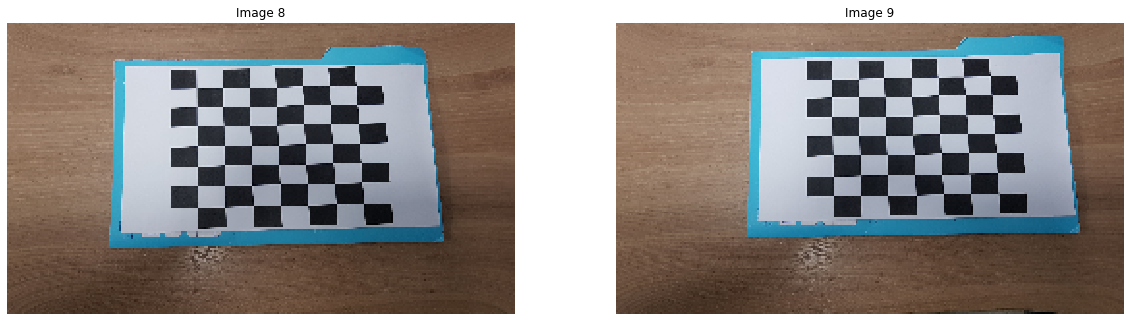

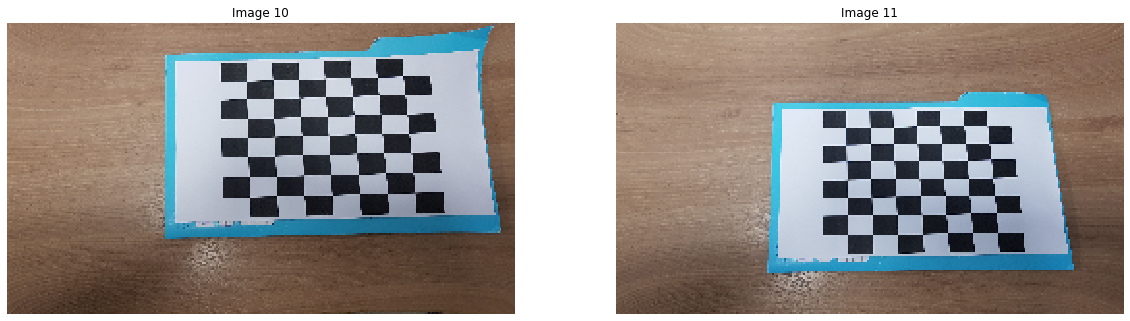

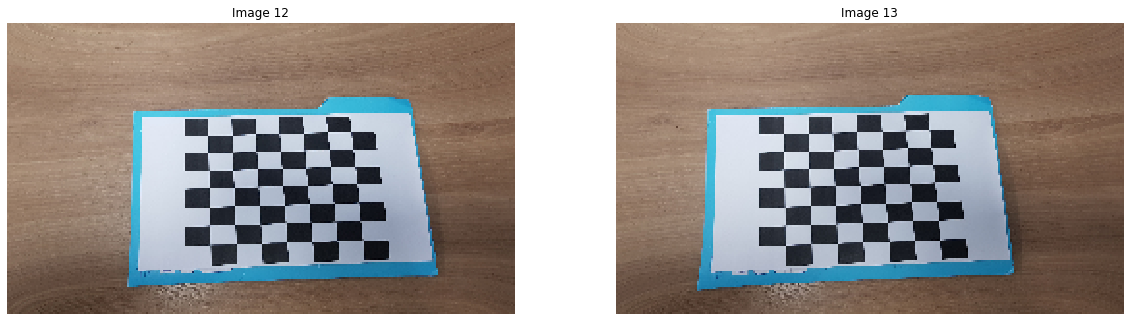

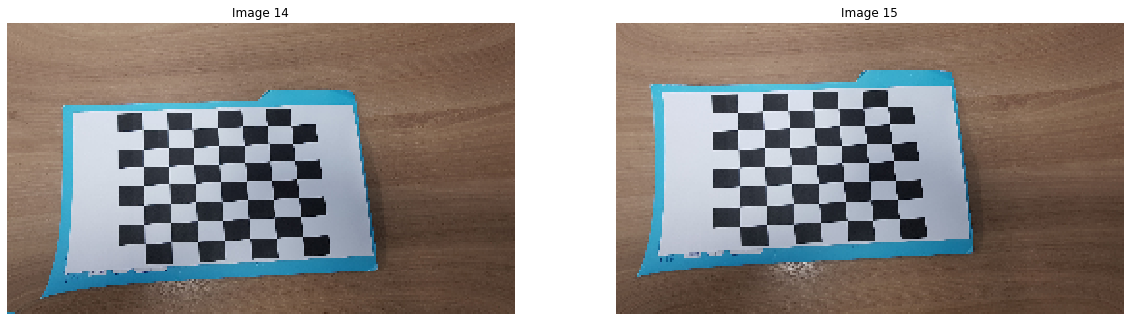

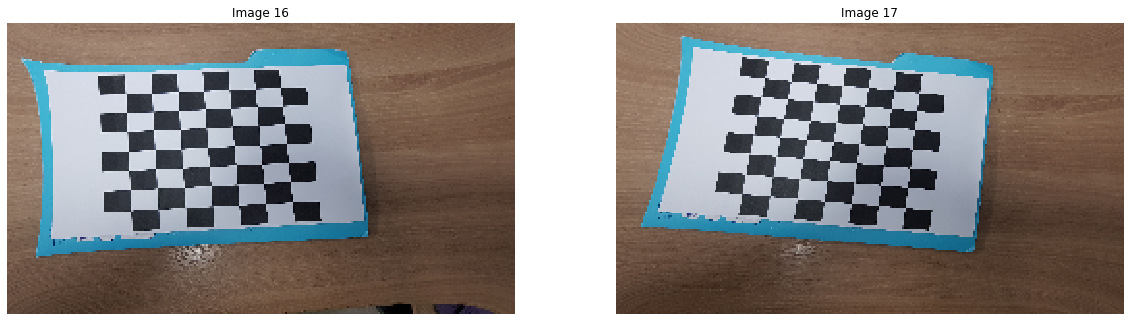

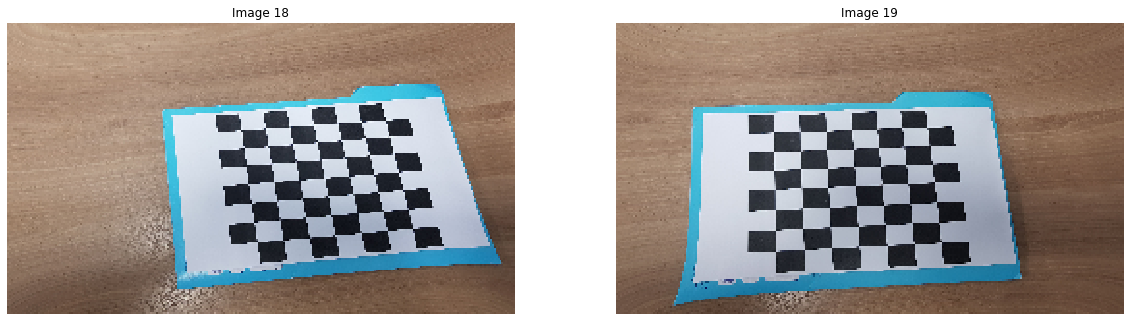

In [17]:
cols = 2
rows = (len(images) + cols - 1) // cols
for r in range(rows):
    plt.figure(figsize = (20, 7))
    for c in range(cols):
        idx_pos = r * cols + c
        if idx_pos >= len(images): continue
        img   = images[idx_pos]
        h,  w = img.shape[:2]
        new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(camera_matrix, dist_coefs, (w,h), 1, (w,h))

        # undistort
        dst = cv2.undistort(img, camera_matrix, dist_coefs, None, new_camera_matrix)

        # crop the image
        x,y,w,h = roi
        dst = dst[y:y+h, x:x+w]
        plt.subplot(1, cols, c + 1)
        plt.title(f"Image {idx_pos}")
        plt.imshow(dst[...,::-1])
        plt.axis("off")
    # for
    plt.show()
# for

# END